In [2]:
import sys
import os
sys.path.append('..')

In [3]:
from src.dataset import ImageDataLoader
from src import config 

import torch
from torchvision import transforms
from pathlib import Path
from src.model import Net
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
def load_model_weights(model, model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model

def get_all_image_files(pathlib_root_folder):
    img_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    img_regex = re.compile('|'.join(img_extensions), re.IGNORECASE)
    image_files = [f for f in pathlib_root_folder.glob('**/*') if f.is_file() and img_regex.search(f.suffix)]
    return image_files


def predict(model, image):
    model.eval()

    with torch.no_grad():
        
        output = model(image.to(DEVICE))
        scores = torch.sigmoid(output)
        predictions = (scores>0.5).float()
        _, pred = torch.min(predictions, 1)

    return pred.item()

In [5]:
hiper_path = '../artifacts/hiper_others_2023-05-12-18-06-48/4_fold_max_acc_checkpoint.pth.tar'
membran_path = '../artifacts/membran_others_2023-05-12-20-31-18/0_fold_max_acc_checkpoint.pth.tar'
sclero_path = '../artifacts/sclero_others_2023-05-12-13-27-54/4_fold_max_acc_checkpoint.pth.tar'
normal_path = '../artifacts/normal_others_2023-05-12-15-45-47/4_fold_max_acc_checkpoint.pth.tar'
podoc_path = '../artifacts/podoc_others_2023-05-17-08-46-23/2_fold_max_acc_checkpoint.pth.tar'
cresc_path = '../artifacts/cresc_others_2023-05-17-13-22-44/2_fold_max_acc_checkpoint.pth.tar'


hiper_model = load_model_weights(Net(net_version="b0", num_classes=2).to(DEVICE), hiper_path)
membran_model = load_model_weights(Net(net_version="b0", num_classes=2).to(DEVICE), membran_path)
sclero_model = load_model_weights(Net(net_version="b0", num_classes=2).to(DEVICE), sclero_path)
normal_model = load_model_weights(Net(net_version="b0", num_classes=2).to(DEVICE), normal_path)
podoc_model = load_model_weights(Net(net_version="b0", num_classes=2).to(DEVICE), podoc_path)
cresc_model = load_model_weights(Net(net_version="b0", num_classes=2).to(DEVICE), cresc_path)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [6]:
result = {
'True Attribute':[],
'Hipercellularity':[],
'Membranous':[],
'Normal':[],
'Sclerosis':[],
'podocytopathy'    :[],
'crescent'    :[],
'Path Prefix'    :[],
'File'    :[],
}
data_path = '../data/raw'
files = get_all_image_files(Path(data_path))

for image_path in files:

    class_name = str(image_path).split('\\')[3]

    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)

    result['True Attribute'].append(class_name)
    result['Hipercellularity'].append(predict(hiper_model, image))
    result['Membranous'].append(predict(membran_model, image))
    result['Normal'].append(predict(normal_model, image))
    result['Sclerosis'].append(predict(sclero_model, image))
    result['podocytopathy'].append(predict(podoc_model, image))
    result['crescent'].append(predict(cresc_model, image))
    result['Path Prefix' ].append(image_path.parent.as_posix())
    result['File'].append(image_path.as_posix())

In [72]:
for i in result.keys():
    print(i, f' {len(result[i])}')
    # arr = np.array(result[i])
    # print(i, f' {np.unique(arr, return_counts=True)}\n')

True Attribute  12514
Hipercellularity  12514
Membranous  12514
Normal  12514
Sclerosis  12514
podocytopathy  12514
crescent  12514
Path Prefix  12514
File  12514


# Overview de como os atributos semânticos foram salvos 

In [73]:
df = pd.DataFrame(result)
df.head()

,True Attribute,Hipercellularity,Membranous,Normal,Sclerosis,podocytopathy,crescent,Path Prefix,File
0,crescentes,0,0,0,1,0,1,../data/raw/crescentes/AZAN,../data/raw/crescentes/AZAN/FIOCRUZ20190122 (1...
1,crescentes,0,0,0,0,0,1,../data/raw/crescentes/AZAN,../data/raw/crescentes/AZAN/FIOCRUZ20190122 (1...
2,crescentes,0,0,0,1,0,1,../data/raw/crescentes/AZAN,../data/raw/crescentes/AZAN/FIOCRUZ20190122 (2...
3,crescentes,0,0,0,0,0,1,../data/raw/crescentes/AZAN,../data/raw/crescentes/AZAN/FIOCRUZ20190122 (2...
4,crescentes,0,0,0,1,0,1,../data/raw/crescentes/AZAN,../data/raw/crescentes/AZAN/FIOCRUZ20190122 (2...


In [129]:
summ = df.groupby(['Hipercellularity', 'Membranous', 'Normal', 'Sclerosis', 'podocytopathy', 'crescent']).agg({'File':'count'}).sort_values(by=['File'],ascending=False)
summ.columns = ['Count']
summ = summ.reset_index()

def create_new_column(row):
    if sum(row[['Hipercellularity', 'Membranous', 'Normal', 'Sclerosis', 'podocytopathy', 'crescent']].values) >1 and row['Normal']==1:
        return 1
    else:
        return 0
    
summ['normal_incoer'] = summ.apply(create_new_column, axis=1)
df['normal_incoer'] = df.apply(create_new_column, axis=1)
summ['Percentage (%)'] = round(summ['Count'] / summ['Count'].sum() *100,2) 

# Agrupamento das Top 10 combinações de Atributos Semânticos 

In [112]:
summ.head(10)

,Hipercellularity,Membranous,Normal,Sclerosis,podocytopathy,crescent,Count,normal_incoer,Percentage (%)
0,0,1,0,0,0,0,2807,0,22.43
1,1,0,0,0,0,0,2156,0,17.23
2,0,0,0,1,0,0,1923,0,15.37
3,0,0,1,0,0,0,1915,0,15.30
4,0,0,0,0,0,0,1065,0,8.51
5,0,0,0,1,0,1,565,0,4.51
6,0,0,1,0,1,0,342,1,2.73
7,1,0,0,0,0,1,273,0,2.18
8,0,0,0,0,1,0,234,0,1.87
9,0,1,0,1,0,0,219,0,1.75


In [131]:
att_columns = ['True Attribute','Hipercellularity', 'Membranous', 'Normal', 'Sclerosis', 'podocytopathy', 'crescent','Path Prefix']
def create_new_column_2(row):
    if sum(row[['Hipercellularity', 'Membranous', 'Normal', 'Sclerosis', 'podocytopathy', 'crescent']].values) <1:
        return 1
    else:
        return 0

df['without_att'] = df.apply(create_new_column_2, axis=1)
df['without_att'] = df.apply(create_new_column_2, axis=1)
df_summary = df[att_columns]

# Imagens que não foram classificadas com nenhum atributo

In [97]:
df_summary[df['without_att']==1].head(10)

,True Attribute,Hipercellularity,Membranous,Normal,Sclerosis,podocytopathy,crescent,Path Prefix
64,crescentes,0,0,0,0,0,0,../data/raw/crescentes/AZAN
67,crescentes,0,0,0,0,0,0,../data/raw/crescentes/AZAN
432,crescentes,0,0,0,0,0,0,../data/raw/crescentes/H_E
652,crescentes,0,0,0,0,0,0,../data/raw/crescentes/PAMS
804,crescentes,0,0,0,0,0,0,../data/raw/crescentes/PAS
1001,crescentes,0,0,0,0,0,0,../data/raw/crescentes/PAS
1106,crescentes,0,0,0,0,0,0,../data/raw/crescentes/PICRO
1266,hipercellularity,0,0,0,0,0,0,../data/raw/hipercellularity/AZAN
1276,hipercellularity,0,0,0,0,0,0,../data/raw/hipercellularity/AZAN
1278,hipercellularity,0,0,0,0,0,0,../data/raw/hipercellularity/AZAN


In [102]:
df_summary[df['without_att']==1].groupby(['True Attribute','Path Prefix']).agg({'Path Prefix':'count'})

Path Prefix
True Attribute      Path Prefix                                                   
Podocitopatia_stain ../data/raw/Podocitopatia_stain/With/AZAN                    2
                    ../data/raw/Podocitopatia_stain/With/HE                      2
                    ../data/raw/Podocitopatia_stain/With/PAS                     2
                    ../data/raw/Podocitopatia_stain/Without/AZAN                10
                    ../data/raw/Podocitopatia_stain/Without/HE                   4
                    ../data/raw/Podocitopatia_stain/Without/PAMS                 2
                    ../data/raw/Podocitopatia_stain/Without/PAS                 21
                    ../data/raw/Podocitopatia_stain/Without/PICRO                1
crescentes          ../data/raw/crescentes/AZAN                                  2
                    ../data/raw/crescentes/H_E                                   1
                    ../data/raw/crescentes/PAMS                                  1
                    ../data/raw/crescentes/PAS                                   2
                    ../data/raw/crescentes/PICRO                                 1
hipercellularity    ../data/raw/hipercellularity/AZAN                            5
                    ../data/raw/hipercellularity/HE                             35
                    ../data/raw/hipercellularity/PAS                            18
                    ../data/raw/hipercellularity/PS                              1
membranous          ../data/raw/membranous/primary_membranous/AZAN               6
                    ../data/raw/membranous/primary_membranous/HE                24
                    ../data/raw/membranous/primary_membranous/PAMS              11
                    ../data/raw/membranous/primary_membranous/PAS               13
                    ../data/raw/membranous/primary_membranous/PICRO              2
                    ../data/raw/membranous/secondary_membranous/AZAN           119
                    ../data/raw/membranous/secondary_membranous/HE             345
                    ../data/raw/membranous/secondary_membranous/PAMS           113
                    ../data/raw/membranous/secondary_membranous/PAS            126
                    ../data/raw/membranous/secondary_membranous/PICRO           75
normal              ../data/raw/normal/AZAN                                      4
                    ../data/raw/normal/HE                                       16
                    ../data/raw/normal/PAMS                                      8
                    ../data/raw/normal/PAS                                       7
                    ../data/raw/normal/PICRO                                     1
sclerosis           ../data/raw/sclerosis/sclerosis/HE                          16
                    ../data/raw/sclerosis/sclerosis/PAMS                         2
                    ../data/raw/sclerosis/sclerosis/PAS                          4
                    ../data/raw/sclerosis/sclerosis_withoutMemb/AZAN             8
                    ../data/raw/sclerosis/sclerosis_withoutMemb/HE              25
                    ../data/raw/sclerosis/sclerosis_withoutMemb/PAMS             8
                    ../data/raw/sclerosis/sclerosis_withoutMemb/PAS             19
                    ../data/raw/sclerosis/sclerosis_withoutMemb/PS               3

## Imagens que foram classificadas com o atributo "Normal" E com alguma outra lesão 

In [88]:
summ[summ['normal_incoer']==1]

,Hipercellularity,Membranous,Normal,Sclerosis,podocytopathy,crescent,File,normal_incoer,Percentage,Percentage (%)
6,0,0,1,0,1,0,342,1,2.73,2.73
15,0,1,1,0,0,0,88,1,0.70,0.70
19,0,0,1,1,0,0,29,1,0.23,0.23
20,1,0,1,0,0,0,24,1,0.19,0.19
21,0,0,1,1,1,0,18,1,0.14,0.14
24,1,0,1,0,1,0,6,1,0.05,0.05
26,0,0,1,0,0,1,4,1,0.03,0.03
28,0,1,1,0,1,0,2,1,0.02,0.02
29,0,1,1,1,0,0,1,1,0.01,0.01


In [130]:
df[df['normal_incoer']==1]

,True Attribute,Hipercellularity,Membranous,Normal,Sclerosis,podocytopathy,crescent,Path Prefix,File,without_att,H M N S P C,normal_incoer
409,crescentes,0,0,1,0,0,1,../data/raw/crescentes/H_E,../data/raw/crescentes/H_E/FIOCRUZ20190123-508...,0,0 0 1 0 0 1,1
981,crescentes,0,0,1,0,0,1,../data/raw/crescentes/PAS,../data/raw/crescentes/PAS/FIOCRUZ20190123-508...,0,0 0 1 0 0 1,1
982,crescentes,0,0,1,0,0,1,../data/raw/crescentes/PAS,../data/raw/crescentes/PAS/FIOCRUZ20190123-509...,0,0 0 1 0 0 1,1
986,crescentes,0,0,1,0,0,1,../data/raw/crescentes/PAS,../data/raw/crescentes/PAS/FIOCRUZ20190123-536...,0,0 0 1 0 0 1,1
1447,hipercellularity,1,0,1,0,0,0,../data/raw/hipercellularity/HE,../data/raw/hipercellularity/HE/2007PC0133AI(1...,0,1 0 1 0 0 0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11998,sclerosis,0,1,1,1,0,0,../data/raw/sclerosis/sclerosis_withoutMemb/PAMS,../data/raw/sclerosis/sclerosis_withoutMemb/PA...,0,0 1 1 1 0 0,1
12324,sclerosis,0,0,1,1,0,0,../data/raw/sclerosis/sclerosis_withoutMemb/PAS,../data/raw/sclerosis/sclerosis_withoutMemb/PA...,0,0 0 1 1 0 0,1
12355,sclerosis,0,0,1,1,0,0,../data/raw/sclerosis/sclerosis_withoutMemb/PAS,../data/raw/sclerosis/sclerosis_withoutMemb/PA...,0,0 0 1 1 0 0,1
12413,sclerosis,0,0,1,1,0,0,../data/raw/sclerosis/sclerosis_withoutMemb/PAS,../data/raw/sclerosis/sclerosis_withoutMemb/PA...,0,0 0 1 1 0 0,1


# Gráfico de frequência dos atributos agrupados

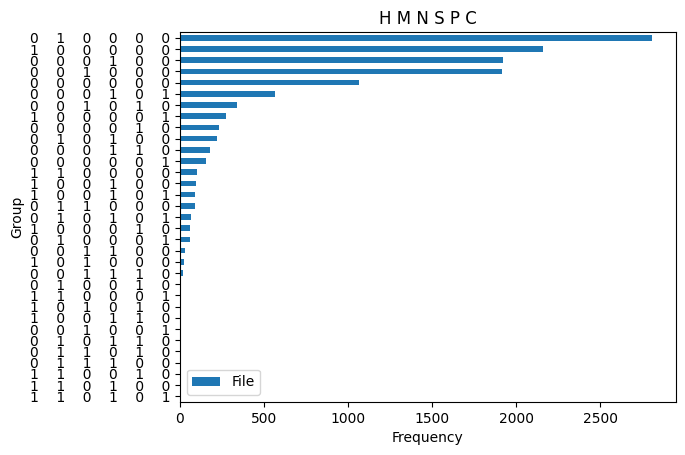

In [128]:

columns_to_concatenate = ['Hipercellularity', 'Membranous', 'Normal', 'Sclerosis', 'podocytopathy', 'crescent']
df['H M N S P C'] = df[columns_to_concatenate].apply(lambda x: '    '.join(x.dropna().astype(str)), axis=1)

gg_2 = df.groupby(['H M N S P C']).agg({'File':'count'}).sort_values(by=['File'],ascending=False)

ax = gg_2.iloc[::-1].plot(kind='barh')
plt.title('Frequency Plot')
plt.xlabel('Frequency')

plt.title('H M N S P C')

plt.xlabel('Frequency')
plt.ylabel('Group')
# Show the plot
plt.show()


In [33]:
df.to_csv('../data/raw/data_index_completed_2.csv',index=False)

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw/data_index_completed_2.csv')

In [4]:
table = df[['Hipercellularity', 'Membranous', 'Normal', 'Sclerosis', 'podocytopathy', 'crescent']].value_counts()

table = pd.DataFrame(table)